In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 import os
 from pathlib import Path

 folder = ""
 project_dir = "03_rnn_tf"

 base_path = Path("/content/drive/My Drive/")
 project_path = base_path / folder / project_dir
 os.chdir(project_path)
 for x in list(project_path.glob("*")):
     if x.is_dir():
         dir_name = str(x.relative_to(project_path))
         os.rename(dir_name, dir_name.split(" ", 1)[0])
 print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/03_rnn_tf


In [ ]:
#  !pip install tensorflow-gpu==2.0.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import check_util.checker as checker
from IPython.display import clear_output

import os
import time
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tensorflow version: 2.15.0
GPU 사용 가능 여부: False


In [ ]:
batch_size = 128
max_epochs = 30
learning_rate = 3e-5
hidden_sizes = [100, 100] # hidden_sizes must be a list

In [ ]:
def preprocess(all_files):
    data_0 = []  # 기온
    data_1 = []  # 강수량
    data_2 = []  # 풍속
    data_3 = []  # 습도
    data_4 = []  # 증기압
    data_5 = []  # 이슬점 온도
    data_6 = []  # 현지 기압
    data_7 = []  # 해면 기압
    data_8 = []  # 지면 온도
    for f in all_files:
        with open(f, encoding='euc-kr') as c:
            csv_reader = csv.reader(c, delimiter=',')
            header = True
            for col in csv_reader:
                if header:
                    header = False
                    continue
                data_0.append(
                    float(col[2])) if col[2] != '' else data_0.append(0.0)
                data_1.append(
                    float(col[3])) if col[3] != '' else data_1.append(0.0)
                data_2.append(
                    float(col[4])) if col[4] != '' else data_2.append(0.0)
                data_3.append(
                    float(col[6])) if col[6] != '' else data_3.append(0.0)
                data_4.append(
                    float(col[7])) if col[7] != '' else data_4.append(0.0)
                data_5.append(
                    float(col[8])) if col[8] != '' else data_5.append(0.0)
                data_6.append(
                    float(col[9])) if col[9] != '' else data_6.append(0.0)
                data_7.append(
                    float(col[10])) if col[10] != '' else data_7.append(0.0)
                data_8.append(
                    float(col[22])) if col[22] != '' else data_8.append(0.0)

    data = np.zeros((len(data_0), 9))
    for i, d in enumerate(data):
        data[i, 0] = data_0[i]
        data[i, 1] = data_1[i]
        data[i, 2] = data_2[i]
        data[i, 3] = data_3[i]
        data[i, 4] = data_4[i]
        data[i, 5] = data_5[i]
        data[i, 6] = data_6[i]
        data[i, 7] = data_7[i]
        data[i, 8] = data_8[i]

    return data.astype(np.float32)

In [ ]:
data_dir = './data/climate_seoul'

train_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'train', '*'))))
val_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'val', '*'))))
test_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'test', '*'))))

In [ ]:
print("shape of train data: {}".format(train_data.shape))
print("shape of val data: {}".format(val_data.shape))
print("shape of test data: {}".format(test_data.shape))

shape of train data: (70133, 9)
shape of val data: (8760, 9)
shape of test data: (8760, 9)


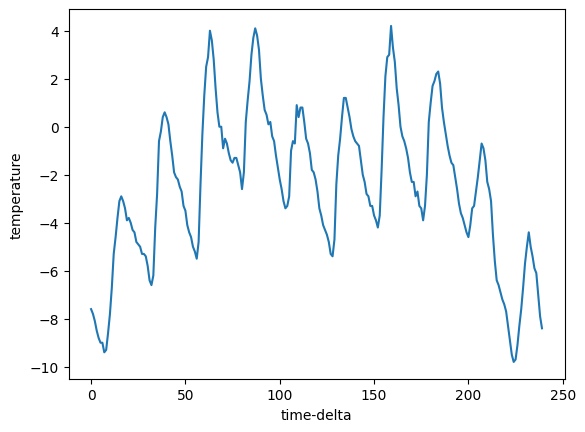

In [ ]:
start = 0
dt = 240
plt.plot(train_data[start:start+dt, 0])
plt.ylabel("temperature")
plt.xlabel("time-delta")
plt.show()

In [ ]:
def make_dataset(data, seq_length=480, target_delay=24, strides=5,
                 mode='train', train_mean=None, train_std=None):

    assert mode in ['train', 'val', 'test']
    if mode != 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    if mode == 'train':
        mean = train_data.mean(axis=(0))
        std = train_data.std(axis=(0))
    else:
        mean = train_mean
        std = train_std
    data = (data - mean) / std

    # 입력, 타겟 데이터 생성
    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay):
        if index % strides == 0:

            sequence.append(data[index:index+seq_length])
            target.append(data[index+seq_length+target_delay][0])

    if mode == 'train':
        return np.array(sequence), np.array(target), mean, std
    else:
        return np.array(sequence), np.array(target)

In [ ]:
train_sequences, train_labels, train_mean, train_std = make_dataset(train_data, mode='train')
val_sequences, val_labels = make_dataset(val_data, mode='val', train_mean=train_mean, train_std=train_std)
test_sequences, test_labels = make_dataset(test_data, mode='test', train_mean=train_mean, train_std=train_std)

In [ ]:
N = BUFFER_SIZE = len(train_sequences) # number of samples in train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))
test_dataset = test_dataset.batch(batch_size)

In [ ]:
def eval_baseline(dataset, loss_fn):
    mean_loss = tf.keras.metrics.Mean()
    for sequences, targets in dataset:

        predictions = sequences[:, -1,0]
        loss = loss_fn(predictions, targets)
        mean_loss(loss)

    print('Baseline Average Loss: {:.4f}'.format(mean_loss.result()))
    return mean_loss.result()

In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()
baseline_loss = eval_baseline(test_dataset, loss_object)

Baseline Average Loss: 0.1058


In [ ]:
for i in range(10):
    data_idx = np.random.randint(len(test_sequences))
    pred = test_sequences[data_idx, -1, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_labels[data_idx] * train_std[0] + train_mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(
        pred, target, pred - target))

예측 기온: 12.2 / 실제 기온: 4.6 / 차이: 7.6
예측 기온: 13.7 / 실제 기온: 15.2 / 차이: -1.5
예측 기온: 14.8 / 실제 기온: 14.1 / 차이: 0.7
예측 기온: 5.7 / 실제 기온: 4.0 / 차이: 1.7
예측 기온: 22.0 / 실제 기온: 22.6 / 차이: -0.6
예측 기온: -3.4 / 실제 기온: -9.9 / 차이: 6.5
예측 기온: 17.8 / 실제 기온: 13.4 / 차이: 4.4
예측 기온: 15.6 / 실제 기온: 10.7 / 차이: 4.9
예측 기온: 24.1 / 실제 기온: 25.9 / 차이: -1.8
예측 기온: 25.4 / 실제 기온: 24.1 / 차이: 1.3


In [ ]:
if tf.test.is_gpu_available():
    print("GPU 사용이 가능합니다.")
    print("TF 2.0으로 넘어오면서 tf.keras.layers.CuDNNLSTM이 없어졌습니다. GPU를 활용하고 싶으신 분은 LSTM Document의 cuDNN 부분을 확인해주세요.")
else:
    print("GPU 사용이 불가능합니다.")
    print("layers.LSTM() 으로 Model을 만들어 보세요.")

GPU 사용이 불가능합니다.
layers.LSTM() 으로 Model을 만들어 보세요.


In [ ]:
model = tf.keras.Sequential()

In [ ]:
num_layers = len(hidden_sizes)
for i in range(num_layers - 1):

    model.add(tf.keras.layers.LSTM(units=100,return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=100))
    model.add(tf.keras.layers.Dense(1))

In [ ]:
for step, (sequences, targets) in enumerate(train_dataset.take(1)):
    predictions = model(sequences)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (128, 480, 100)           44000     
                                                                 
 lstm_1 (LSTM)               (128, 100)                80400     
                                                                 
 dense (Dense)               (128, 1)                  101       
                                                                 
Total params: 124501 (486.33 KB)
Trainable params: 124501 (486.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checker.model_check(model)

네트워크를 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.
같은 모델을 class형식으로 짜면 다음과 같이 짤 수 있습니다.

class my_model(tf.keras.Model):
    def __init__(self, hidden_sizes):
        super(my_model, self).__init__(name = '')
        self.lstm_a = layers.LSTM(hidden_sizes[0], return_sequences = True)
        self.lstm_b = layers.LSTM(hidden_sizes[-1], return_sequences = False)
        self.dense = layers.Dense(1)
        
    def call(self, input_tensor, training = False):
        x = self.lstm_a(input_tensor)
        x = self.lstm_b(x)
        x = self.dense(x)
        
        return x



In [ ]:
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate= learning_rate),
              metrics=['mse'])

In [ ]:
checkpoint_path = "./train/exp_rnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only = True,
                                                 save_freq = 'epoch',
                                                 verbose=1)

In [ ]:
model.fit(train_dataset, steps_per_epoch = len(train_data)/batch_size,
          validation_data = val_dataset,
          validation_steps= 1,
          epochs= 5,
          callbacks= [cp_callback])

Epoch 1/5
548/547 [==============================] - ETA: 0s - loss: 0.1936 - mse: 0.1936
Epoch 1: saving model to ./train/exp_rnn/cp-0001.ckpt
547/547 [==============================] - 1087s 2s/step - loss: 0.1936 - mse: 0.1936 - val_loss: 0.1633 - val_mse: 0.1633
Epoch 2/5
548/547 [==============================] - ETA: 0s - loss: 0.0969 - mse: 0.0969
Epoch 2: saving model to ./train/exp_rnn/cp-0002.ckpt
547/547 [==============================] - 1078s 2s/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.1444 - val_mse: 0.1444
Epoch 3/5
548/547 [==============================] - ETA: 0s - loss: 0.0827 - mse: 0.0827
Epoch 3: saving model to ./train/exp_rnn/cp-0003.ckpt
547/547 [==============================] - 1075s 2s/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.1358 - val_mse: 0.1358
Epoch 4/5
548/547 [==============================] - ETA: 0s - loss: 0.0768 - mse: 0.0768
Epoch 4: saving model to ./train/exp_rnn/cp-0004.ckpt
547/547 [==============================] - 1079s 2s/ste

In [ ]:
# 아래의 모델 불러오기를 정확히 구현했는지 확인하기 위해 새로 모델을 선언하여 학습 이전 상태로 초기화
model = tf.keras.Sequential()
num_layers = len(hidden_sizes)

for i in range(num_layers - 1):
    model.add(tf.keras.layers.LSTM(units=100,return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=100))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate= learning_rate),
              metrics=['mse'])

In [ ]:
# inputs을 넣어 모델을 생성
for sequences, targets in train_dataset.take(1):
    outputs = model(sequences)
    print(outputs)

tf.Tensor(
[[-0.05838965]
 [-0.078935  ]
 [ 0.06190686]
 [ 0.01283665]
 [-0.0868214 ]
 [-0.04818048]
 [ 0.00429319]
 [-0.02100241]
 [-0.02670721]
 [-0.00412819]
 [-0.02224857]
 [-0.05228007]
 [-0.09304772]
 [-0.04406723]
 [ 0.12306383]
 [-0.05760324]
 [ 0.0474202 ]
 [-0.04737669]
 [ 0.01312601]
 [-0.00380148]
 [-0.0628529 ]
 [ 0.05439385]
 [ 0.09483856]
 [-0.09875339]
 [ 0.02365526]
 [ 0.06762677]
 [-0.05750861]
 [ 0.04572984]
 [-0.05437286]
 [ 0.06291934]
 [ 0.00309764]
 [ 0.03927505]
 [ 0.00765654]
 [ 0.00898014]
 [ 0.03896155]
 [-0.0288622 ]
 [-0.12897888]
 [ 0.10697499]
 [-0.00175066]
 [-0.01626439]
 [ 0.0413318 ]
 [ 0.00592775]
 [-0.08100776]
 [-0.10949693]
 [-0.06523068]
 [-0.06528506]
 [-0.13860814]
 [ 0.00857825]
 [-0.03950358]
 [ 0.00132402]
 [ 0.01006557]
 [-0.00467905]
 [ 0.00773312]
 [-0.10381221]
 [ 0.03135105]
 [-0.04895857]
 [-0.0104574 ]
 [ 0.10782155]
 [ 0.04447967]
 [ 0.08022859]
 [-0.07877857]
 [ 0.0207163 ]
 [-0.03333247]
 [ 0.00238719]
 [ 0.0363972 ]
 [ 0.00455949]

In [ ]:
_, test_loss = model.evaluate(test_dataset, steps=len(test_sequences)/batch_size)

12/12 [==============================] - 13s 822ms/step - loss: 0.0864 - mse: 0.0864


In [ ]:
for i in range(10):
    data_idx = np.random.randint(len(test_sequences))
    pred = model(test_sequences[data_idx:data_idx+1, :, :]).numpy()[0, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_labels[data_idx] * train_std[0] + train_mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(
        pred, target, pred - target))

예측 기온: 7.1 / 실제 기온: 7.8 / 차이: -0.7
예측 기온: 12.7 / 실제 기온: 15.2 / 차이: -2.5
예측 기온: 31.2 / 실제 기온: 29.1 / 차이: 2.1
예측 기온: 13.7 / 실제 기온: 16.0 / 차이: -2.3
예측 기온: 11.4 / 실제 기온: 14.1 / 차이: -2.7
예측 기온: 22.3 / 실제 기온: 20.7 / 차이: 1.6
예측 기온: 26.8 / 실제 기온: 23.3 / 차이: 3.5
예측 기온: 28.0 / 실제 기온: 27.1 / 차이: 0.9
예측 기온: 13.5 / 실제 기온: 16.3 / 차이: -2.8
예측 기온: 5.5 / 실제 기온: 4.6 / 차이: 0.9


- 날씨와 같은 시계열 정보를 다룰 수 있다.
- RNN을 설계하고 시간 순서상 미래의 정보를 예측하는 모델을 학습시킬 수 있다.
- 상식적인 수준의 베이스라인을 도입하여 학습한 모델의 성능을 검증할 수 있다.